In [9]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

%run utils.py
%run environment.py
%run agent.py
%run plotting.py

%load_ext lab_black
sns.set_theme()

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
params = Params(epsilon=0.1, n_runs=5, numEpisodes=100)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.05, n_runs=5, numEpisodes=100)

In [3]:
env = Environment(params)

In [4]:
learner = Qlearning(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

In [5]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)

for run in range(params.n_runs):  # Run several times to account for stochasticity
    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:

            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.qtable[state, action] = learner.update(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count

In [6]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})

In [7]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,10.0,634.0,10.0
1,1,10.0,435.0,20.0
2,2,0.0,61.0,20.0
3,3,10.0,5110.0,30.0
4,4,10.0,1873.0,40.0
...,...,...,...,...
495,95,0.0,6686.0,550.0
496,96,0.0,8723.0,560.0
497,97,10.0,1330.0,570.0
498,98,10.0,12.0,580.0


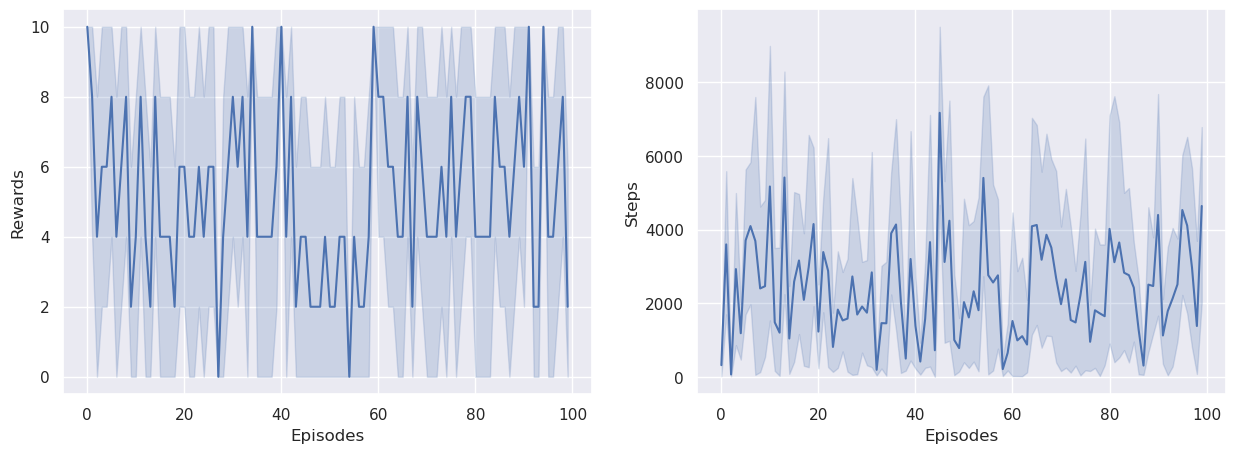

In [10]:
plot_steps_and_rewards(res)